# Real projective coordinates on data set of image patches

In this example, we explore the topology of a collection of image patches capturing line segments, which, as we will show using persistent homology and projective coordinates, are parametrized by the projective plane $RP^2$.
Each image patch is a square $d \times d$ region of pixels.
Each pixel can be thought of as a dimension, so each patch lives in $\mathbb{R}^{d \times d}$, and a collection of patches can be thought of as a Euclidean point cloud in $\mathbb{R}^{d \times d}$.

In [1]:
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams
from dreimac import ProjectiveCoords, GeometryUtils, GeometryExamples, PlotUtils, ProjectiveMapUtils

%load_ext autoreload
%autoreload 2

We now examine the collection of patches which hold oriented, slightly blurry line segments at varying distances from the center of the patch.
We start by considering a small sample of these patches.
Below, the "dim" variable sets the patch resolution, and the "sigma" variable sets the blurriness (a larger sigma means blurrier line segments). 

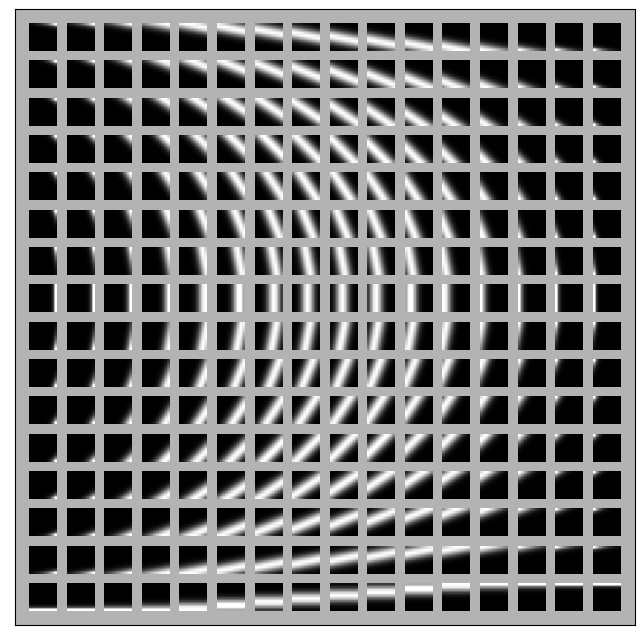

In [2]:
small_sample = GeometryExamples.line_patches(dim=10, n_angles=16, n_offsets=16, sigma=0.25)

plt.figure(figsize=(8, 8))
PlotUtils.plot_patches(small_sample, zoom=2)
plt.gca().set_facecolor((0.7, 0.7, 0.7))

Now let's compute persistence diagrams for this collection of patches with both $\mathbb{Z}/2$ coefficients and $\mathbb{Z}/3$ coefficients up to $H_2$.

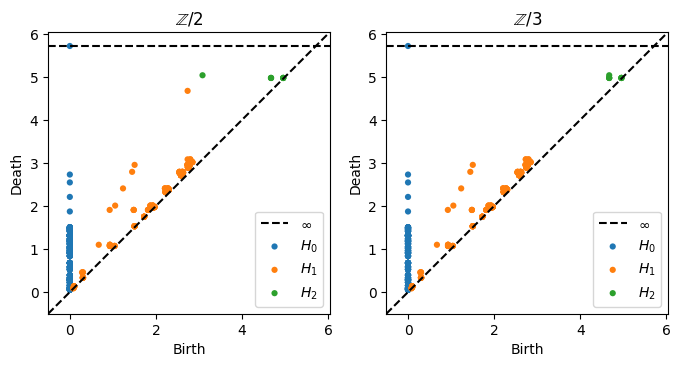

In [3]:
plt.figure(figsize=(8, 4))
for i,prime in enumerate([2,3]):
    pd = ripser(small_sample, coeff=prime, maxdim=2)['dgms']
    plt.subplot(1,2,i+1) ; plot_diagrams(pd) ; _ = plt.title("$\mathbb{Z}/" + str(prime) + "$")

There are two high-persistence classes in the persistence diagram with $\mathbb{Z}/2\mathbb{Z}$ coefficients that do not show up in the persistence diagram with $\mathbb{Z} / 3\mathbb{Z}$ coefficients.
This is the signature of the projective plane $RP^2$.
To verify this, we will map these patches to $RP^2$ using real projective coordinates.

In [4]:
X = GeometryExamples.line_patches(dim=10, n_angles=200, n_offsets=200, sigma=0.25)
#from sklearn.manifold import Isomap
#embedding = Isomap(n_components=3, n_neighbors=20)
#embedding.fit(X)
#X_transformed = embedding.fit_transform(X)

In [5]:
#pc = ProjectiveCoords(embedding.dist_matrix_, n_landmarks=300)
pc = ProjectiveCoords(X, n_landmarks=300)
proj_coords = pc.get_coordinates(proj_dim=2, perc=0.99, cocycle_idx=0)

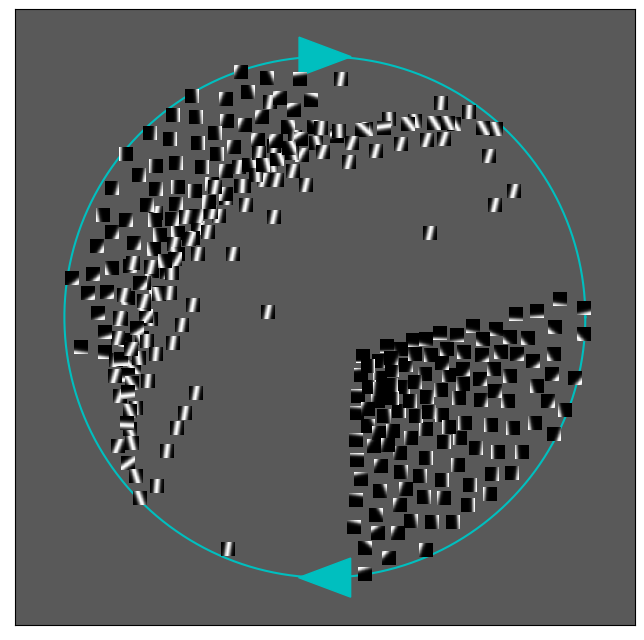

In [6]:
subsample = GeometryUtils.get_greedy_perm_pc(proj_coords, 300)['perm']
stereo_projection_dim_red_subsample = ProjectiveMapUtils.get_stereo_proj_codim1(proj_coords[subsample, :])

plt.figure(figsize=(8, 8))
PlotUtils.imscatter(stereo_projection_dim_red_subsample, X[subsample, :], 10)
_ = PlotUtils.plot_proj_boundary()